In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/batches.meta
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/test_batch
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar-10-dataset/cifar-10-batches-py/readme.html


In [2]:
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [3]:
DATA_ROOT = "/kaggle/input/cifar-10-dataset"

transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

transform_val = T.Compose([
    T.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=False,   # IMPORTANT: Kaggle already has the data
    transform=transform_train,
)

val_dataset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT,
    train=False,
    download=False,
    transform=transform_val,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.norm2 = nn.LayerNorm(dim)

        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), need_weights=False)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x


In [5]:
#sanity check, should output 50000 10000
print(len(train_dataset), len(val_dataset))


50000 10000


In [6]:
class ViTSmall(nn.Module):
    def __init__(
        self,
        image_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4.0,
        dropout=0.1,
    ):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim)
        )
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim, num_heads, mlp_ratio, dropout
            )
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return self.head(x[:, 0])


In [7]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        total += x.size(0)
    return total_loss / total


def train_n_batches(model, optimizer, loader, n_batches):
    model.train()
    it = iter(loader)
    for _ in range(n_batches):
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(loader)
            x, y = next(it)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        optimizer.step()


In [8]:
class HyperGradient:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        lr=3.3e-4,
        wd=0.07,
        delta=1e-4,
        hyper_lr=1e-6,  # CHANGED: Reduced default from 1e-2 to 1e-6
        probe_batches=5
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.lr = lr
        self.wd = wd
        self.delta = delta
        self.hyper_lr = hyper_lr
        self.probe_batches = probe_batches

    def _make_opt(self, model, lr, wd):
        return torch.optim.AdamW(
            model.parameters(), lr=lr, weight_decay=wd
        )

    # NEW: Helper to evaluate faster
    @torch.no_grad()
    def evaluate_subset(self, model, loader, limit_batches=20):
        model.eval()
        total_loss, total = 0.0, 0
        for i, (x, y) in enumerate(loader):
            if i >= limit_batches: break
            x, y = x.to(device), y.to(device)
            loss = F.cross_entropy(model(x), y)
            total_loss += loss.item() * x.size(0)
            total += x.size(0)
        return total_loss / total

    def step(self):
        grads = {}

        for name in ["lr", "wd"]:
            base = getattr(self, name)
            # Ensure epsilon isn't too tiny
            eps = self.delta * max(base, 1e-8)

            losses = {}
            for sign in [+1, -1]:
                val = max(base + sign * eps, 1e-8)
                clone = copy.deepcopy(self.model)
                opt = self._make_opt(
                    clone,
                    lr=val if name == "lr" else self.lr,
                    wd=val if name == "wd" else self.wd,
                )

                train_n_batches(
                    clone, opt, self.train_loader, self.probe_batches
                )
                # CHANGED: Use fast subset evaluation
                losses[sign] = self.evaluate_subset(clone, self.val_loader, limit_batches=20)

            grads[name] = (losses[+1] - losses[-1]) / (2 * eps)

        # CHANGED: Robust Update Logic with Clipping
        # 1. Update LR with safety clip
        lr_grad = grads["lr"]
        lr_update = self.hyper_lr * lr_grad
        # Cap change to max 20% of current value to prevent explosion
        max_lr_change = 0.20 * self.lr
        if abs(lr_update) > max_lr_change:
            lr_update = max_lr_change if lr_update > 0 else -max_lr_change
        
        self.lr -= lr_update

        # 2. Update WD with safety clip
        wd_grad = grads["wd"]
        wd_update = self.hyper_lr * wd_grad
        max_wd_change = 0.20 * self.wd
        if abs(wd_update) > max_wd_change:
            wd_update = max_wd_change if wd_update > 0 else -max_wd_change
            
        self.wd -= wd_update

        # 3. Final Clamps
        self.lr = float(torch.clamp(torch.tensor(self.lr), 1e-6, 1e-2))
        self.wd = float(torch.clamp(torch.tensor(self.wd), 1e-6, 1.0))

        return grads

In [9]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd  # Required for saving results

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# The specific seeds requested by your partner
SEEDS = [38042, 217401, 637451, 207796, 45921]

# Training duration matching your paper (90 epochs)
EPOCHS = 90
HYPER_INTERVAL = 2  # How often HGD updates (epochs)

# Master list to store every single data point for CSV
full_data_log = []

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def set_seed(seed):
    """Sets all random seeds for deterministic reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@torch.no_grad()
def evaluate_metrics(model, loader):
    """Calculates Loss and Accuracy on a given loader."""
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        total += x.size(0)
        
        # Calculate Accuracy
        _, preds = logits.max(1)
        correct += preds.eq(y).sum().item()
        
    return total_loss / total, correct / total

# ==========================================
# 3. MAIN EXPERIMENT LOOP
# ==========================================
print(f"Starting Multi-Seed Experiment.")
print(f"Seeds: {SEEDS}")
print(f"Config: {EPOCHS} Epochs per seed | ViT-Small (Patch=8, Dim=192)")
print(f"Estimated duration: ~3.5 to 4 hours") 

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"STARTING SEED: {seed}")
    print(f"{'='*80}")
    
    # 1. Reset Environment
    set_seed(seed)
    
    # 2. Initialize Model (Partner's Config: Small/Fast)
    model = ViTSmall(
        image_size=32,      
        patch_size=8,       # 16 tokens (Fast)
        embed_dim=192,      # 192 dim (Lightweight)
        depth=12,           
        num_heads=3,        
        mlp_ratio=4.0,      
        dropout=0.1         
    ).to(device)

    # 3. Initialize HyperGradient Wrapper
    hg = HyperGradient(
        model,
        train_loader,
        val_loader,
        lr=3.3e-4,      # Baseline start
        wd=0.07,        # Baseline start
        hyper_lr=1e-8,  # Safe step size for hyper-updates
    )

    # 4. Initialize Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=hg.lr,
        weight_decay=hg.wd
    )

    # 5. Training Loop for this Seed
    for epoch in range(EPOCHS):
        t0 = time.time()
        model.train()

        running_loss = 0.0
        running_correct = 0
        seen = 0

        # --- Batch Loop ---
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

            # Track Train Stats
            running_loss += loss.item() * x.size(0)
            _, preds = logits.max(1)
            running_correct += preds.eq(y).sum().item()
            seen += x.size(0)

        # Calculate Epoch Stats
        epoch_train_loss = running_loss / seen
        epoch_train_acc = running_correct / seen
        epoch_time = time.time() - t0

        # --- Hypergradient Step ---
        hg_update_msg = ""
        if epoch % HYPER_INTERVAL == 0:
            # Run the probe and update LR/WD
            grads = hg.step()
            
            # Apply new values to optimizer
            for param_group in optimizer.param_groups:
                param_group['lr'] = hg.lr
                param_group['weight_decay'] = hg.wd
            
            hg_update_msg = f" [HG UPDATE: dLR={grads['lr']:.1e}, dWD={grads['wd']:.1e}]"

        # --- Validation Step ---
        val_loss, val_acc = evaluate_metrics(model, val_loader)

        # --- Logging Data ---
        # 1. Print to Console (The "Training Log")
        print(
            f"[Seed {seed} | Ep {epoch:02d}] "
            f"Train (L={epoch_train_loss:.4f} A={epoch_train_acc:.1%}) | "
            f"Val (L={val_loss:.4f} A={val_acc:.1%}) | "
            f"Hyper (LR={hg.lr:.2e} WD={hg.wd:.2e}) | "
            f"Time={epoch_time:.1f}s{hg_update_msg}"
        )

        # 2. Save to Master List
        log_entry = {
            'Seed': seed,
            'Epoch': epoch,
            'Train_Loss': epoch_train_loss,
            'Train_Acc': epoch_train_acc,
            'Val_Loss': val_loss,
            'Val_Acc': val_acc,
            'LR': hg.lr,
            'WD': hg.wd,
            'Time_Sec': epoch_time
        }
        full_data_log.append(log_entry)

    # --- End of Seed Safety Save ---
    # Save after every seed so data is safe if Colab crashes
    current_df = pd.DataFrame(full_data_log)
    current_df.to_csv('hypergradient_results.csv', index=False)
    print(f"--> Completed Seed {seed}. Saved checkpoint to 'hypergradient_results.csv'")

print("\n" + "="*80)
print("ALL SEEDS COMPLETED SUCCESSFULLY.")
print("Final data saved to 'hypergradient_results.csv'")
print("="*80)

Starting Multi-Seed Experiment.
Seeds: [38042, 217401, 637451, 207796, 45921]
Config: 90 Epochs per seed | ViT-Small (Patch=8, Dim=192)
Estimated duration: ~3.5 to 4 hours

STARTING SEED: 38042
[Seed 38042 | Ep 00] Train (L=1.9746 A=24.4%) | Val (L=1.8507 A=30.4%) | Hyper (LR=2.64e-04 WD=6.99e-02) | Time=18.2s [HG UPDATE: dLR=7.9e+05, dWD=1.0e+04]
[Seed 38042 | Ep 01] Train (L=1.7575 A=33.7%) | Val (L=1.6493 A=39.6%) | Hyper (LR=2.64e-04 WD=6.99e-02) | Time=17.7s
[Seed 38042 | Ep 02] Train (L=1.6716 A=37.9%) | Val (L=1.6174 A=41.1%) | Hyper (LR=2.11e-04 WD=6.99e-02) | Time=18.2s [HG UPDATE: dLR=2.3e+05, dWD=-3.4e+02]
[Seed 38042 | Ep 03] Train (L=1.6090 A=40.5%) | Val (L=1.5695 A=42.9%) | Hyper (LR=2.11e-04 WD=6.99e-02) | Time=18.4s
[Seed 38042 | Ep 04] Train (L=1.5671 A=42.1%) | Val (L=1.5531 A=43.9%) | Hyper (LR=1.69e-04 WD=6.99e-02) | Time=18.9s [HG UPDATE: dLR=7.9e+03, dWD=4.3e+03]
[Seed 38042 | Ep 05] Train (L=1.5194 A=44.2%) | Val (L=1.4390 A=48.4%) | Hyper (LR=1.69e-04 WD=6.99e-

NameError: name 'all_results' is not defined

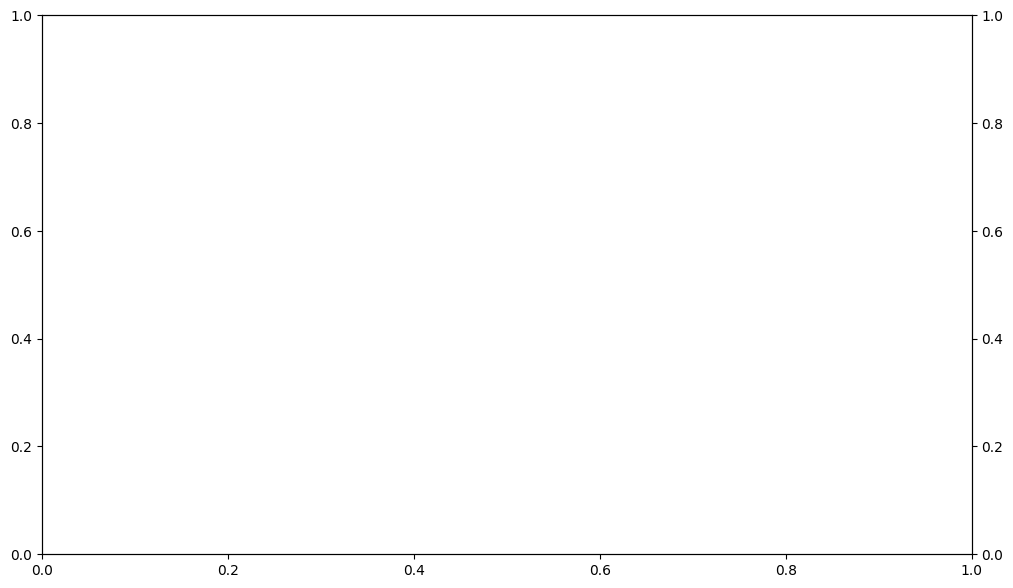

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup the Plot
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx() # Right axis for Learning Rate

# Colors
color_loss = 'tab:red'
color_lr = 'tab:blue'

# 2. Iterate through every seed to plot individual "faint" lines
# This proves to your partner that every seed worked, not just the average
for seed in SEEDS:
    # Extract data
    s_val = all_results[seed]['val_loss']
    s_lr = all_results[seed]['lr']
    epochs = range(len(s_val))
    
    # Plot faint lines (alpha=0.2)
    ax1.plot(epochs, s_val, color=color_loss, alpha=0.15, linewidth=1)
    ax2.step(epochs, s_lr, where='post', color=color_lr, alpha=0.15, linewidth=1, linestyle='--')

# 3. Calculate and Plot the MEAN (Bold Lines)
val_losses_matrix = np.array([all_results[s]['val_loss'] for s in SEEDS])
lr_matrix = np.array([all_results[s]['lr'] for s in SEEDS])

mean_val = np.mean(val_losses_matrix, axis=0)
mean_lr = np.mean(lr_matrix, axis=0)

# Plot Mean Loss (Thick Red Line)
ax1.plot(epochs, mean_val, color=color_loss, linewidth=2.5, label=f'Mean Val Loss (N={len(SEEDS)})')

# Plot Mean LR (Thick Blue Dashed Line)
# Note: We use the mean LR, though ideally they should be identical if deterministic
ax2.step(epochs, mean_lr, where='post', color=color_lr, linewidth=2.5, linestyle='--', label='Mean Adaptive LR')

# 4. Styling
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Loss', color=color_loss, fontsize=12)
ax2.set_ylabel('Learning Rate', color=color_lr, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_loss)
ax2.tick_params(axis='y', labelcolor=color_lr)
ax1.grid(True, alpha=0.3)

# Combined Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.title(f'Hypergradient Dynamics: Robustness Across {len(SEEDS)} Random Seeds', fontsize=14, pad=50)
plt.tight_layout()

# Save
plt.savefig('hgd_robustness_spaghetti.png', dpi=300)
plt.show()